In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
def solution(b1, b2, b3):
    t1 = (b1/2) * max(0, (b2-b1)/3 - np.max([0, -b1, -2*(b3 + b1)]))
    t2 = (b2/2) * max(0, min(b2/2, 2*(b3 + b2)/5) - max(0, (b2 - b1)/3))
    #t3 = (b3/2) * max(0, 2*(b3 + b2)/5 - np.max([0, 2*b3, -(b1 + b3)/2]))  # error in Example 5.1 in the Lasserre 1983 paper
    t3 = (b3/2) * max(0, 2*(b3 + b2)/5 - np.max([0, 2*b3, 2*(b1 + b3)]))
    return t1 + t2 + t3

In [4]:
b1 = 1
b2 = 2
b3 = 3

In [5]:
solution(b1, b2, b3)

0.8333333333333334

In [6]:
N = 2001
x_max = y_max = 1.5

x = np.linspace(0, x_max, N)
y = np.linspace(0, y_max, N)

X, Y = np.meshgrid(x, y)

In [7]:
I1 = -X + Y <= b1
I2 = 2*X + Y <= b2
I3 = X/2 - Y <= b3
I4 = X >= 0
I5 = Y >= 0
I = I1 & I2 & I3 & I4 & I5

In [8]:
V = np.zeros_like(X)
V[I] = 1

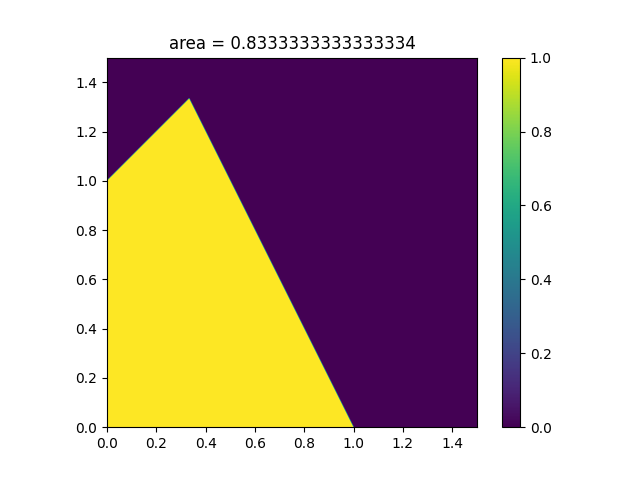

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(V, extent=[0, x_max, 0, y_max], origin='lower')
ax.set_title(f'area = {solution(b1, b2, b3)}')
fig.colorbar(im, ax=ax);

In [10]:
A = np.array([[ -1,  1],
              [  2,  1],
              [1/2, -1],
              [ -1,  0],
              [  0, -1]])

b = np.array([b1, b2, b3, 0, 0])

In [11]:
XY = np.array([X.flatten(), Y.flatten()])

In [12]:
A.shape, XY.shape

((5, 2), (2, 4004001))

In [13]:
I_XY = [(x <= b).all() for x in (A @ XY).T]

In [14]:
V2 = np.zeros_like(X)
V2.flat[np.where(I_XY)] = 1

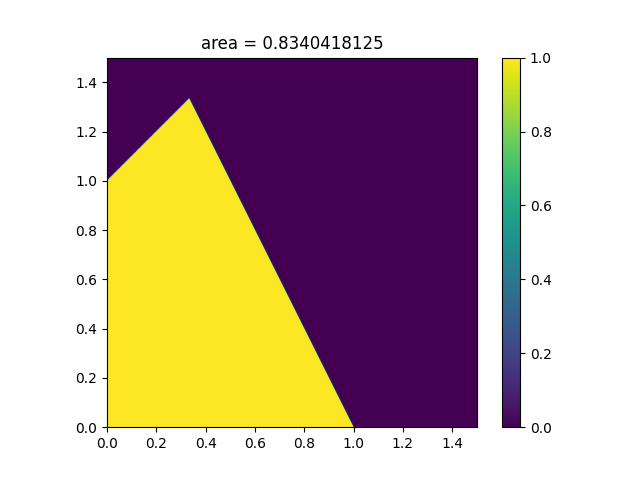

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(V2, extent=[0, x_max, 0, y_max], origin='lower')
ax.set_title(f'area = {len(np.where(I_XY)[0]) * (x[1] - x[0]) * (y[1] - y[0])}')
fig.colorbar(im, ax=ax);

In [16]:
def one_level(i, j, A, b):
    a_ij = A[i, j]
    assert a_ij != 0
    
    M, N = A.shape
    assert N == 2
    
    A_tilde = np.empty(M-1)
    b_tilde = np.empty(M-1)
    
    k_prime = 0
    for k in range(M):
        if k == i:
            continue
        l_prime = 0
        for l in range(N):
            if l == j:
                continue
            A_tilde[k_prime] = A[k, l] - A[k, j] * A[i, l] / A[i, j]
            l_prime += 1
        b_tilde[k_prime] = b[k] - A[k, j] / A[i, j] * b[i]
        k_prime += 1
    
    I_positive = A_tilde > 0
    I_negative = A_tilde < 0

    if sum(I_positive) == 0 or sum(I_negative) == 0:
        vol = np.inf
    else:
        vol = max(0, np.min(b_tilde[I_positive.flat] / A_tilde[I_positive.flat]) - np.max(b_tilde[I_negative.flat] / A_tilde[I_negative.flat]))
            
    return vol

In [17]:
b1/2 * one_level(0, 1, A, b) + b2/2 * one_level(1, 1, A, b) + b3/2 * one_level(2, 1, A, b)

0.8333333333333334

In [18]:
b1/(1*2) * one_level(0, 0, A, b) + b2/(2*2) * one_level(1, 0, A, b) + b3/(0.5*2) * one_level(2, 0, A, b) 

0.8333333333333333

In [19]:
def lass_2d(A, b, j=0):
    M, N = A.shape
    assert N == 2
    assert b.ndim == 1 and len(b) == M
    
    vol = 0
    
    for i, b_i in enumerate(b):
        if not np.allclose(b_i, 0):
            vol += b_i / (2 * abs(A[i, j])) * one_level(i, j, A, b)
        
    return vol

In [20]:
def lass_vol(A, b):
    M, N = A.shape
    assert b.ndim == 1 and len(b) == M
    
    # base case
    if N == 1:
        I_positive = A.flat > 0
        I_negative = A.flat < 0
        
        if sum(I_positive) == 0 or sum(I_negative) == 0:
            vol = np.inf
        else:
            vol = max(0, np.min(b[I_positive] / A.flat[I_positive]) - np.max(b[I_negative] / A.flat[I_negative]))
        return vol

    vol = 0
    A_tilde = np.empty((M-1, N-1))        
    b_tilde = np.empty(M-1)
    
    for i in range(M):
        if np.allclose(b[i], 0):
            continue
            
        k_prime = 0
        for k in range(M):
            if k == i:
                continue
            for j in range(0, N-1):
                A_tilde[k_prime, j] = A[k, j] - A[k, -1] * A[i, j] / A[i, -1]
            b_tilde[k_prime] = b[k] - A[k, -1] / A[i, -1] * b[i]
            k_prime += 1
        
        vol += b[i] / abs(A[i, -1]) * lass_vol(A_tilde, b_tilde) 
    return vol / N

In [21]:
lass_2d(A, b, j=0)

0.8333333333333333

In [22]:
lass_2d(A, b, j=1)

0.8333333333333334

In [23]:
solution(b1, b2, b3)

0.8333333333333334

In [24]:
lass_vol(A, b) 

0.8333333333333334

In [25]:
N = 100

np.random.seed(888)

for i in range(N):
    b1, b2, b3 = 10*np.random.rand(3)
    b = np.array([b1, b2, b3, 0, 0])
    
    sol = solution(b1, b2, b3)
    v0 = lass_2d(A, b, j=0)
    v1 = lass_2d(A, b, j=1)
    v2 = lass_vol(A, b)
    
    print(sol)
    print(v0)
    print(v1)
    print(v2)
    print('---------------------')
    
    if not np.allclose(sol, v0) or not np.allclose(sol, v1) or not np.allclose(sol, v2):
        print(':(')
        break

0.6770779700504065
0.6770779700504065
0.6770779700504065
0.6770779700504065
---------------------
4.165710323746659
4.394075200483588
4.394075200483588
4.394075200483588
---------------------
:(


In [26]:
N = 2001
x_max = 2.5
y_max = 5

x = np.linspace(-0.1, x_max, N)
y = np.linspace(-0.1, y_max, N)

X, Y = np.meshgrid(x, y)

In [27]:
I1 = -X + Y <= b1
I2 = 2*X + Y <= b2
I3 = X/2 - Y <= b3
I4 = X >= 0
I5 = Y >= 0
I = I1 & I2 & I3 & I4 & I5

In [28]:
V = np.zeros_like(X)
V[I] = 1

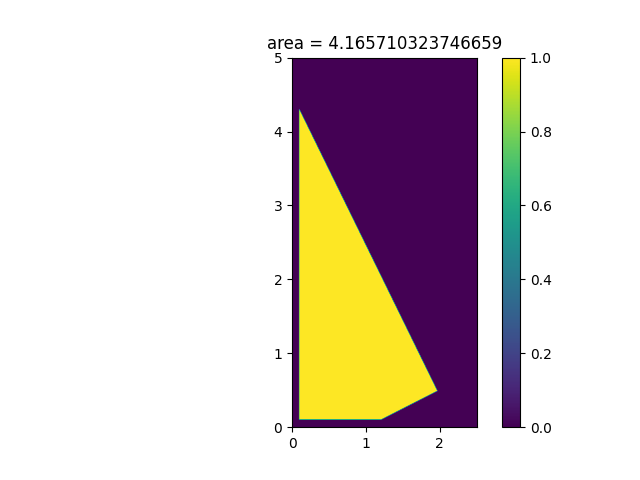

In [29]:
fig, ax = plt.subplots()
im = ax.imshow(V, extent=[0, x_max, 0, y_max], origin='lower')
ax.set_title(f'area = {solution(b1, b2, b3)}')
fig.colorbar(im, ax=ax);

In [30]:
XY = np.array([X.flatten(), Y.flatten()])

In [31]:
I_XY = [(x <= b).all() for x in (A @ XY).T]

In [32]:
V2 = np.zeros_like(X)
V2.flat[np.where(I_XY)] = 1

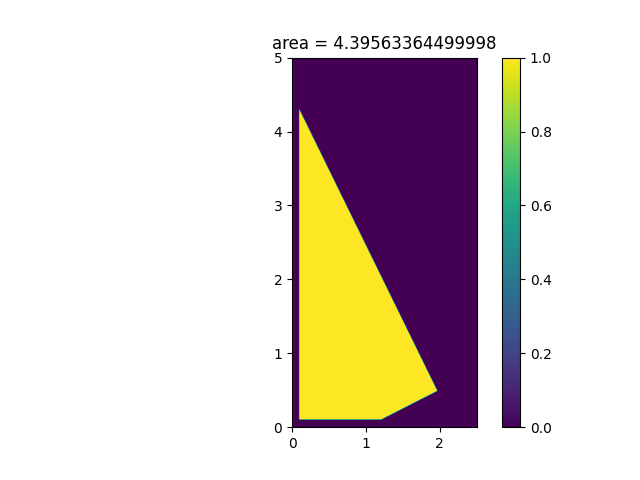

In [33]:
fig, ax = plt.subplots()
im = ax.imshow(V2, extent=[0, x_max, 0, y_max], origin='lower')
ax.set_title(f'area = {len(np.where(I_XY)[0]) * (x[1] - x[0]) * (y[1] - y[0])}')
fig.colorbar(im, ax=ax);